# Tutorial 3: Greedy Wavelet Matching and Intensity Metrics

**Duration:** ~50-60 minutes

## Learning Objectives

By the end of this tutorial, you will understand:

1. **The time-domain approach** to spectral matching using wavelets
2. **What tapered cosine wavelets are** and their properties
3. **The greedy algorithm** for iterative wavelet placement
4. **Arias Intensity (AI)** - energy-based ground motion metric
5. **Cumulative Absolute Velocity (CAV)** - motion-based metric
6. **How AI constraints preserve** ground motion character
7. **Comparing FFT vs GWM** methods

---

## Prerequisites

- Complete Tutorials 1 and 2
- Understand response spectra and SDOF systems
- Familiar with FFT matching approach

---

## Section 1: The Time-Domain Approach - Why Wavelets?

### Recap: FFT vs Time-Domain

In Tutorial 2, we learned that **FFT matching**:
- Works in frequency domain
- Adjusts all frequencies globally
- Achieves excellent spectral match
- But may increase intensity significantly

**Greedy Wavelet Matching (GWM)** takes a different approach:
- Works in time domain
- Adds localized "wavelets" to fill spectral gaps
- Each wavelet affects primarily one frequency
- Explicitly constrains intensity growth

### The Wavelet Concept

**What is a wavelet?** A localized oscillation - it's concentrated in both time and frequency.

**Analogy:** Think of tuning a piano:
- Instead of adjusting all strings at once (FFT approach)
- You tap and adjust one string at a time (wavelet approach)
- Each string (wavelet) primarily affects one note (frequency)

**Key idea:** Add small, targeted corrections iteratively until the spectrum matches.

---

## Setup: Import Libraries and Load Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
import sys
import os

# Configure matplotlib
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['lines.linewidth'] = 1.5

# Add the spectral_matching package
sys.path.insert(0, os.path.abspath('../src'))

from spectral_matching import (
    load_acceleration_record,
    load_target_spectrum,
    response_spectrum,
    piecewise_exact_solver,
    greedy_wavelet_match,
    tapered_cosine_wavelet,
    baseline_correction,
    scale_to_target_band,
    arias_intensity,
    cumulative_absolute_velocity,
    cumulative_metric
)

print("✓ Libraries loaded!")

✓ Libraries loaded!


In [2]:
# Load El Centro earthquake and target spectrum
time, acceleration, dt = load_acceleration_record("../src/data/elcentro_NS.dat.txt")
acceleration = baseline_correction(acceleration, time, order=2)

# Define period grid and target
periods = np.linspace(0.05, 3.0, 300)
periods_target, target_spectrum = load_target_spectrum("../src/data/uhs_el_centro.csv", periods)

# Scale to target band
period_band = [0.2, 1.0]
acceleration_scaled, scale_factor = scale_to_target_band(
    acceleration, dt, periods, target_spectrum, band=period_band
)

print(f"✓ Data loaded and preprocessed")
print(f"  Duration: {time[-1]:.1f}s, dt={dt:.4f}s")
print(f"  Target period band: {period_band[0]}-{period_band[1]}s")

✓ Data loaded and preprocessed
  Duration: 53.7s, dt=0.0200s
  Target period band: 0.2-1.0s


---

## Section 2: The Tapered Cosine Wavelet

### Mathematical Form

The tapered cosine wavelet is defined as:

$$w(t) = \cos\left(\omega_d (t - t_0) + \phi\right) \cdot \exp\left(-\frac{(t - t_0)^2}{\gamma^2}\right)$$

Where:
- $\omega_d = 2\pi f \sqrt{1 - \zeta^2}$ = damped frequency
- $t_0$ = center time (where wavelet is placed)
- $\phi$ = phase shift for alignment
- $\gamma = 1.178 \cdot f^{-0.93}$ = tapering parameter (frequency-dependent)
- $\zeta$ = damping ratio (0.05)

### Creating and Visualizing a Wavelet

In [3]:
# Create a wavelet for a 0.5s period (2 Hz frequency)
target_time = 10.0  # Place wavelet at t=10s
target_period = 0.5  # 0.5 second period
target_frequency = 1.0 / target_period
damping = 0.05

# Generate the wavelet
wavelet, max_response, response_sign = tapered_cosine_wavelet(
    time, target_time, target_frequency, dt, damping
)

print(f"Wavelet generated for:")
print(f"  Period: {target_period} s (frequency: {target_frequency} Hz)")
print(f"  Placed at time: {target_time} s")
print(f"  Maximum SDOF response: {max_response:.4f} m/s²")
print(f"  Response sign: {'+' if response_sign > 0 else '-'}")

Wavelet generated for:
  Period: 0.5 s (frequency: 2.0 Hz)
  Placed at time: 10.0 s
  Maximum SDOF response: 4.2377 m/s²
  Response sign: +


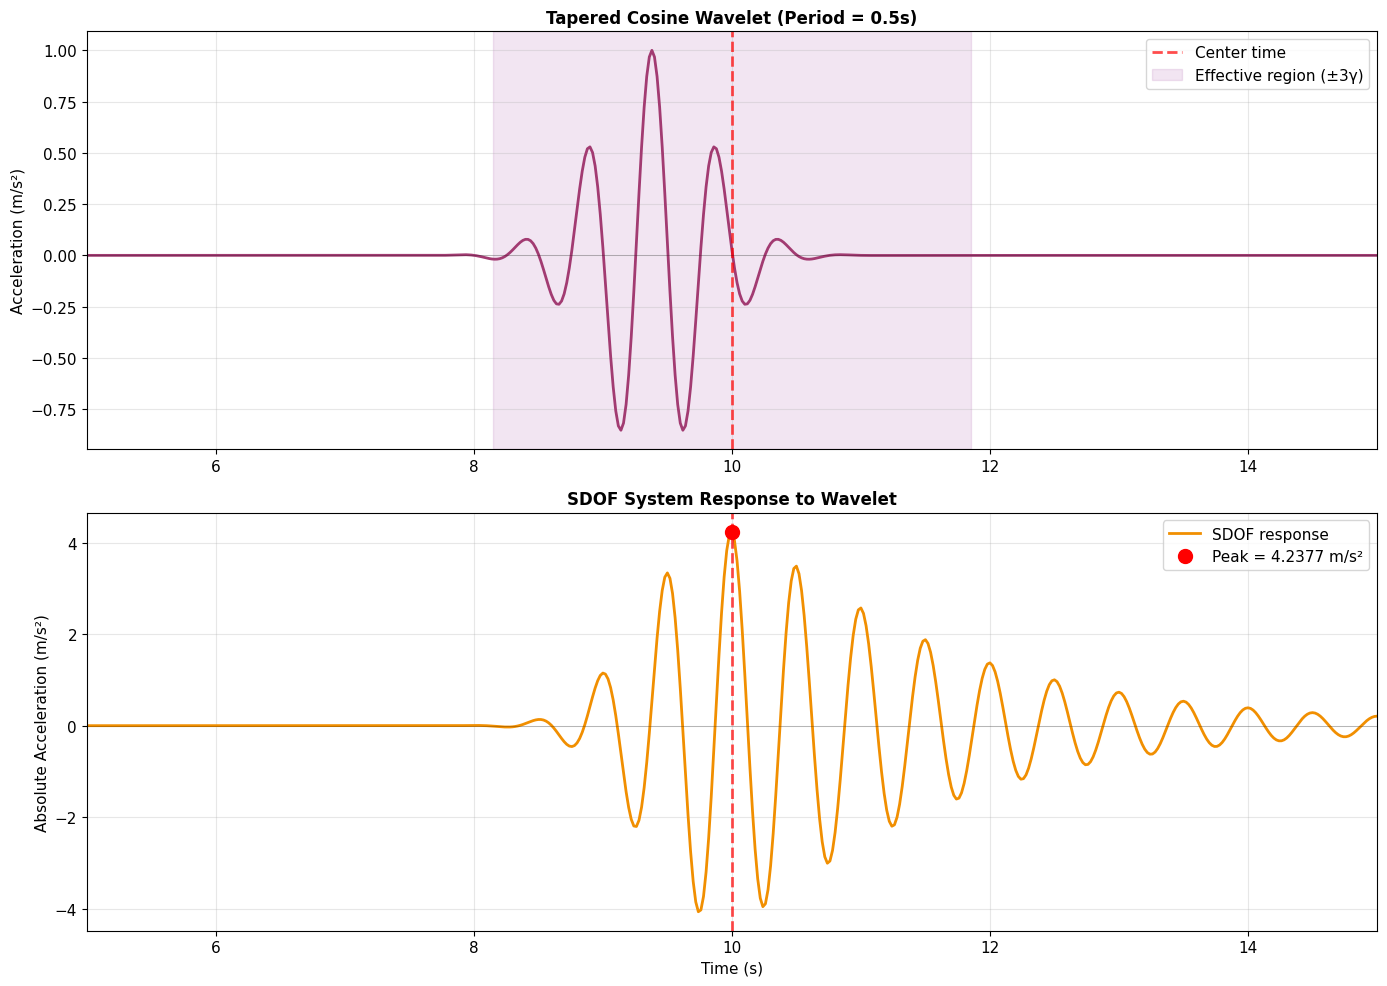


💡 Key Observations:
1. Wavelet is localized in time (decays via Gaussian envelope)
2. Oscillates at the target frequency (0.5s period)
3. SDOF response peaks near center time (phase aligned)
4. Effective width: ~3.7s (99% of energy within ±3γ)


In [4]:
# Visualize the wavelet in time domain
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Top: Wavelet time history
axes[0].plot(time, wavelet, color='#A23B72', linewidth=2)
axes[0].axvline(x=target_time, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Center time')
axes[0].axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)

# Shade the effective region (±3γ)
gamma = 1.178 * (target_frequency ** -0.93)
axes[0].axvspan(target_time - 3*gamma, target_time + 3*gamma, 
               alpha=0.1, color='purple', label=f'Effective region (±3γ)')

axes[0].set_ylabel('Acceleration (m/s²)', fontsize=11)
axes[0].set_title('Tapered Cosine Wavelet (Period = 0.5s)', fontsize=12, fontweight='bold')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([target_time - 5, target_time + 5])

# Bottom: Response of SDOF system to this wavelet
omega_n = 2 * np.pi * target_frequency
wavelet_response = piecewise_exact_solver(wavelet, dt, omega_n, damping)

axes[1].plot(time, wavelet_response, color='#F18F01', linewidth=2, label='SDOF response')
axes[1].axvline(x=target_time, color='red', linestyle='--', linewidth=2, alpha=0.7)
axes[1].axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)

# Mark the peak response
peak_idx = np.argmax(np.abs(wavelet_response))
axes[1].plot(time[peak_idx], wavelet_response[peak_idx], 'ro', markersize=10,
            label=f'Peak = {abs(wavelet_response[peak_idx]):.4f} m/s²')

axes[1].set_xlabel('Time (s)', fontsize=11)
axes[1].set_ylabel('Absolute Acceleration (m/s²)', fontsize=11)
axes[1].set_title('SDOF System Response to Wavelet', fontsize=12, fontweight='bold')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([target_time - 5, target_time + 5])

plt.tight_layout()
plt.show()

print("\n💡 Key Observations:")
print("1. Wavelet is localized in time (decays via Gaussian envelope)")
print("2. Oscillates at the target frequency (0.5s period)")
print(f"3. SDOF response peaks near center time (phase aligned)")
print(f"4. Effective width: ~{6*gamma:.1f}s (99% of energy within ±3γ)")

### Frequency Localization: Wavelet Response Spectrum

Now let's see which periods (frequencies) this wavelet affects:

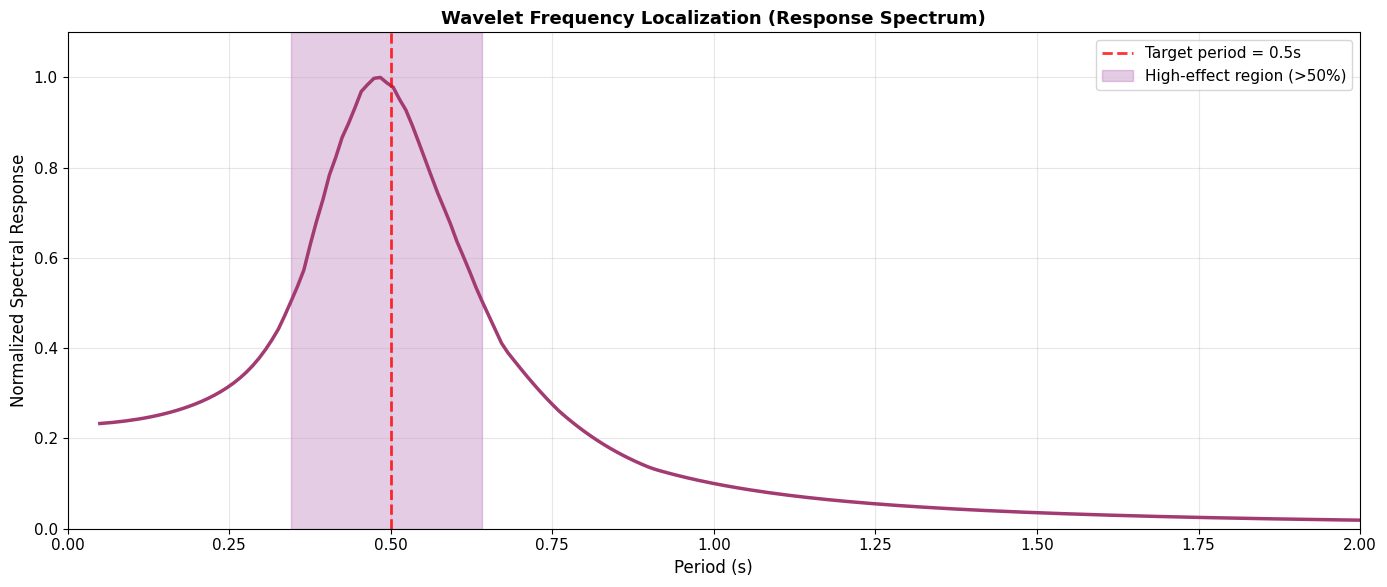


💡 Frequency Localization:
The wavelet primarily affects periods near 0.5s
Effect drops off rapidly away from the target period
This is why we can use wavelets for targeted spectral correction!


In [5]:
# Compute response spectrum of the wavelet
wavelet_spectrum = response_spectrum(wavelet, dt, periods, damping=0.05)

# Normalize to see relative effects
wavelet_spectrum_normalized = wavelet_spectrum / np.max(wavelet_spectrum)

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(periods, wavelet_spectrum_normalized, color='#A23B72', linewidth=2.5)
ax.axvline(x=target_period, color='red', linestyle='--', linewidth=2, alpha=0.8, 
          label=f'Target period = {target_period}s')

# Shade the region where wavelet has >50% effect
half_max_mask = wavelet_spectrum_normalized > 0.5
if np.any(half_max_mask):
    periods_effective = periods[half_max_mask]
    ax.axvspan(periods_effective[0], periods_effective[-1], 
              alpha=0.2, color='purple', label='High-effect region (>50%)')

ax.set_xlabel('Period (s)', fontsize=12)
ax.set_ylabel('Normalized Spectral Response', fontsize=12)
ax.set_title('Wavelet Frequency Localization (Response Spectrum)', fontsize=13, fontweight='bold')
ax.set_xlim([0, 2])
ax.set_ylim([0, 1.1])
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Frequency Localization:")
print(f"The wavelet primarily affects periods near {target_period}s")
print(f"Effect drops off rapidly away from the target period")
print(f"This is why we can use wavelets for targeted spectral correction!")

---

## Section 3: Understanding Intensity Metrics

Before diving into the full GWM algorithm, let's understand the intensity metrics that constrain it.

### Arias Intensity (AI) - Energy-Based Metric

**Formula:**
$$AI = \frac{\pi}{2g} \int_0^T a(t)^2 \, dt$$

Where:
- $g$ = gravity (9.80665 m/s²)
- $a(t)$ = ground acceleration
- $T$ = total duration

**Physical meaning:**
- Measures total energy released in the earthquake
- Proportional to integral of squared acceleration
- Units: m/s (despite being based on acceleration!)
- Correlates with potential for structural damage

**Why it matters:**
- Higher AI = more violent shaking overall
- Used in liquefaction potential assessment
- Building codes limit AI for matched records

### Cumulative Absolute Velocity (CAV) - Motion-Based Metric

**Formula:**
$$CAV = \int_0^T |a(t)| \, dt$$

**Physical meaning:**
- Measures total amount of motion (regardless of direction)
- Simple integral of absolute acceleration
- Units: m/s
- Correlates with non-structural damage and duration effects

**Why it matters:**
- Sensitive to duration of shaking
- Used in seismic codes (PEER-NGA guidelines)
- Indicates potential for cumulative damage

### Computing Intensity Metrics

In [6]:
# Compute AI and CAV for the scaled record
AI_scaled = arias_intensity(acceleration_scaled, dt)
CAV_scaled = cumulative_absolute_velocity(acceleration_scaled, dt)

print(f"Intensity Metrics for Scaled El Centro:")
print(f"="*50)
print(f"Arias Intensity (AI):           {AI_scaled:.4f} m/s")
print(f"Cumulative Absolute Velocity:   {CAV_scaled:.4f} m/s")
print(f"\nPeak Ground Acceleration:       {np.max(np.abs(acceleration_scaled)):.4f} m/s²")
print(f"Duration:                        {time[-1]:.2f} s")

Intensity Metrics for Scaled El Centro:
Arias Intensity (AI):           2.2418 m/s
Cumulative Absolute Velocity:   15.8658 m/s

Peak Ground Acceleration:       3.7861 m/s²
Duration:                        53.74 s


### Cumulative Build-Up Over Time

Both metrics can be computed cumulatively to see how intensity builds up during the earthquake:

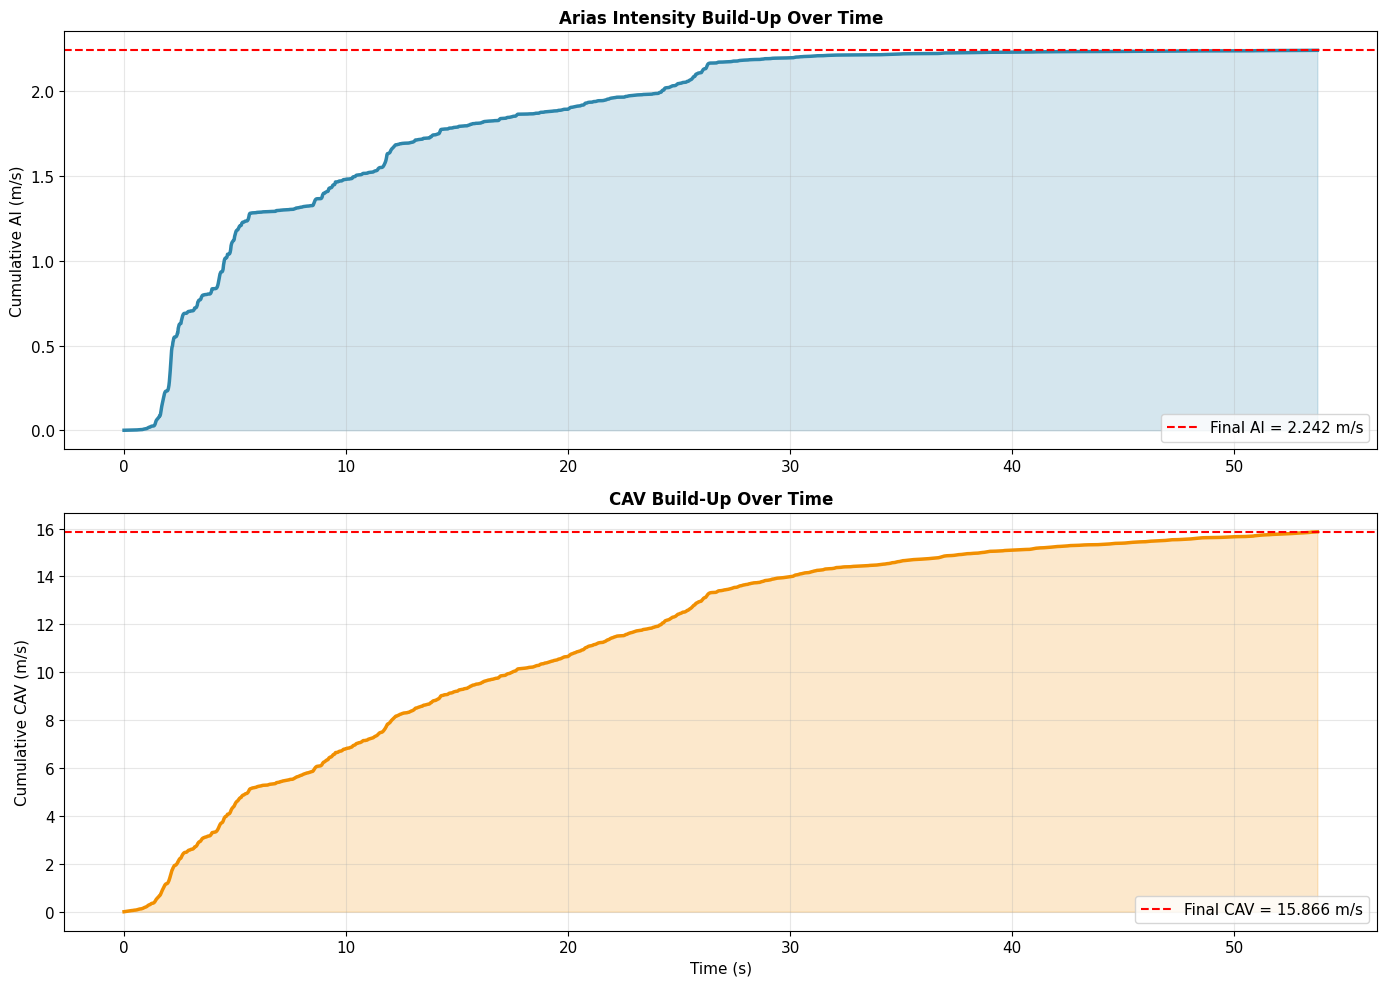


💡 Interpretation:
- Steeper slopes indicate more intense shaking periods
- AI grows faster during strong motion phases (squared acceleration)
- CAV grows more steadily throughout the earthquake
- Most intensity accumulates in the first 10-15 seconds


In [7]:
# Compute cumulative AI and CAV
AI_cumulative = cumulative_metric(acceleration_scaled, dt, metric='AI')
CAV_cumulative = cumulative_metric(acceleration_scaled, dt, metric='CAV')

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Top: Cumulative Arias Intensity
axes[0].plot(time, AI_cumulative, color='#2E86AB', linewidth=2.5)
axes[0].axhline(y=AI_scaled, color='red', linestyle='--', linewidth=1.5, 
               label=f'Final AI = {AI_scaled:.3f} m/s')
axes[0].fill_between(time, 0, AI_cumulative, alpha=0.2, color='#2E86AB')
axes[0].set_ylabel('Cumulative AI (m/s)', fontsize=11)
axes[0].set_title('Arias Intensity Build-Up Over Time', fontsize=12, fontweight='bold')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Bottom: Cumulative CAV
axes[1].plot(time, CAV_cumulative, color='#F18F01', linewidth=2.5)
axes[1].axhline(y=CAV_scaled, color='red', linestyle='--', linewidth=1.5,
               label=f'Final CAV = {CAV_scaled:.3f} m/s')
axes[1].fill_between(time, 0, CAV_cumulative, alpha=0.2, color='#F18F01')
axes[1].set_xlabel('Time (s)', fontsize=11)
axes[1].set_ylabel('Cumulative CAV (m/s)', fontsize=11)
axes[1].set_title('CAV Build-Up Over Time', fontsize=12, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("- Steeper slopes indicate more intense shaking periods")
print("- AI grows faster during strong motion phases (squared acceleration)")
print("- CAV grows more steadily throughout the earthquake")
print("- Most intensity accumulates in the first 10-15 seconds")

---

## Section 4: The Greedy Wavelet Matching Algorithm

### Algorithm Overview

```
Initialize: acceleration = scaled_acceleration
            AI_max = AI_initial × 1.05  (5% cap)

FOR iteration = 1 to max_iterations:
    
    Step 1: Compute current response spectrum
    Step 2: Find period with WORST mismatch (greedy choice)
    Step 3: Determine wavelet placement time
    Step 4: Generate tapered cosine wavelet for that period
    Step 5: Calculate wavelet amplitude to close gap
    Step 6: Constrain amplitude using AI inequality
    Step 7: Add scaled wavelet to acceleration
    Step 8: Check convergence (tolerance met?)
    
END FOR
```

### Manual Implementation of One Iteration

Let's walk through one complete iteration step-by-step.

#### Step 1: Compute Current Response Spectrum

In [8]:
# Start with scaled acceleration
acc_current = acceleration_scaled.copy()

# Only work with periods in the target band
band_mask = (periods >= period_band[0]) & (periods <= period_band[1])
periods_in_band = periods[band_mask]
target_in_band = target_spectrum[band_mask]

# Compute spectrum
spectrum_current = response_spectrum(acc_current, dt, periods_in_band, damping=0.05)

print("Step 1: Current spectrum computed")
print(f"  Working with {len(periods_in_band)} periods in band [{period_band[0]}, {period_band[1]}]s")

Step 1: Current spectrum computed
  Working with 81 periods in band [0.2, 1.0]s


#### Step 2: Find Period with Maximum Mismatch (The Greedy Choice)

In [9]:
# Compute mismatch at each period
mismatch = np.abs(target_in_band - spectrum_current)
relative_mismatch = mismatch / (target_in_band + 1e-12)

# Find the worst mismatch (greedy choice)
index_max = np.argmax(mismatch)
period_max = periods_in_band[index_max]
frequency_max = 1.0 / period_max

mismatch_value = mismatch[index_max]
relative_mismatch_value = relative_mismatch[index_max]

print("Step 2: Greedy choice made")
print(f"  Worst mismatch at period: {period_max:.3f} s ({frequency_max:.2f} Hz)")
print(f"  Target:  {target_in_band[index_max]:.3f} m/s²")
print(f"  Current: {spectrum_current[index_max]:.3f} m/s²")
print(f"  Gap:     {mismatch_value:.3f} m/s² ({relative_mismatch_value*100:.1f}%)")

Step 2: Greedy choice made
  Worst mismatch at period: 0.553 s (1.81 Hz)
  Target:  7.539 m/s²
  Current: 9.963 m/s²
  Gap:     2.424 m/s² (32.2%)


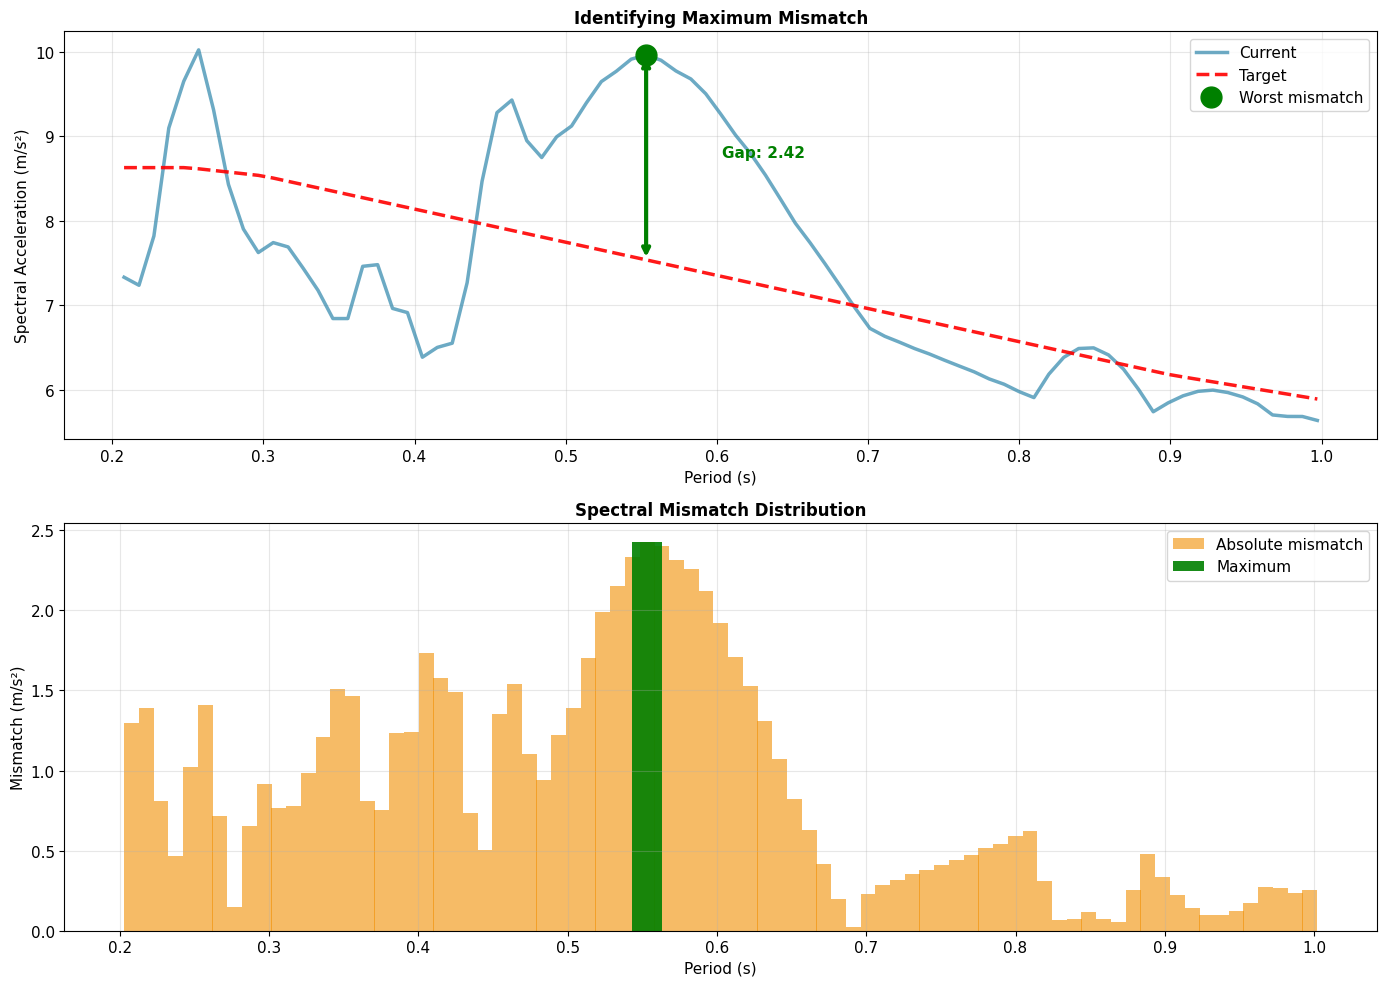


💡 The Greedy Strategy:
Each iteration targets the WORST mismatch first
This ensures monotonic improvement in the worst-case error


In [10]:
# Visualize the mismatch
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Top: Spectra comparison
axes[0].plot(periods_in_band, spectrum_current, color='#2E86AB', linewidth=2.5, 
            label='Current', alpha=0.7)
axes[0].plot(periods_in_band, target_in_band, 'r--', linewidth=2.5, 
            label='Target', alpha=0.9)
axes[0].plot(period_max, spectrum_current[index_max], 'go', markersize=15, 
            label='Worst mismatch', zorder=5)

# Draw arrow showing gap
axes[0].annotate('', xy=(period_max, target_in_band[index_max]), 
                xytext=(period_max, spectrum_current[index_max]),
                arrowprops=dict(arrowstyle='<->', color='green', lw=3))
axes[0].text(period_max + 0.05, (target_in_band[index_max] + spectrum_current[index_max])/2,
            f'Gap: {mismatch_value:.2f}', fontsize=11, color='green', fontweight='bold')

axes[0].set_xlabel('Period (s)', fontsize=11)
axes[0].set_ylabel('Spectral Acceleration (m/s²)', fontsize=11)
axes[0].set_title('Identifying Maximum Mismatch', fontsize=12, fontweight='bold')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# Bottom: Mismatch distribution
axes[1].bar(periods_in_band, mismatch, width=0.01, color='#F18F01', alpha=0.6, label='Absolute mismatch')
axes[1].bar(period_max, mismatch_value, width=0.02, color='green', alpha=0.9, label='Maximum')
axes[1].set_xlabel('Period (s)', fontsize=11)
axes[1].set_ylabel('Mismatch (m/s²)', fontsize=11)
axes[1].set_title('Spectral Mismatch Distribution', fontsize=12, fontweight='bold')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 The Greedy Strategy:")
print("Each iteration targets the WORST mismatch first")
print("This ensures monotonic improvement in the worst-case error")

#### Step 3: Determine Wavelet Placement Time

**Strategy:** Place the wavelet where the SDOF system at this period has its strongest response to the current acceleration.

**Why?** This is where adding motion will have the most effect on that period's spectral value.

In [13]:
# Compute SDOF response at the critical period
omega_n = 2 * np.pi * frequency_max
response = piecewise_exact_solver(acc_current, dt, omega_n, damping_ratio=0.05)

# Find peak response time
peak_index = np.argmax(np.abs(response))
placement_time = time[peak_index]
response_sign = np.sign(response[peak_index])

print("Step 3: Wavelet placement determined")
print(f"  Place wavelet at time: {placement_time:.2f} s")
print(f"  Peak response value: {response[peak_index]:.3f} m/s²")
print(f"  Response sign: {'+' if response_sign > 0 else '-'}")

Step 3: Wavelet placement determined
  Place wavelet at time: 2.18 s
  Peak response value: 9.963 m/s²
  Response sign: +


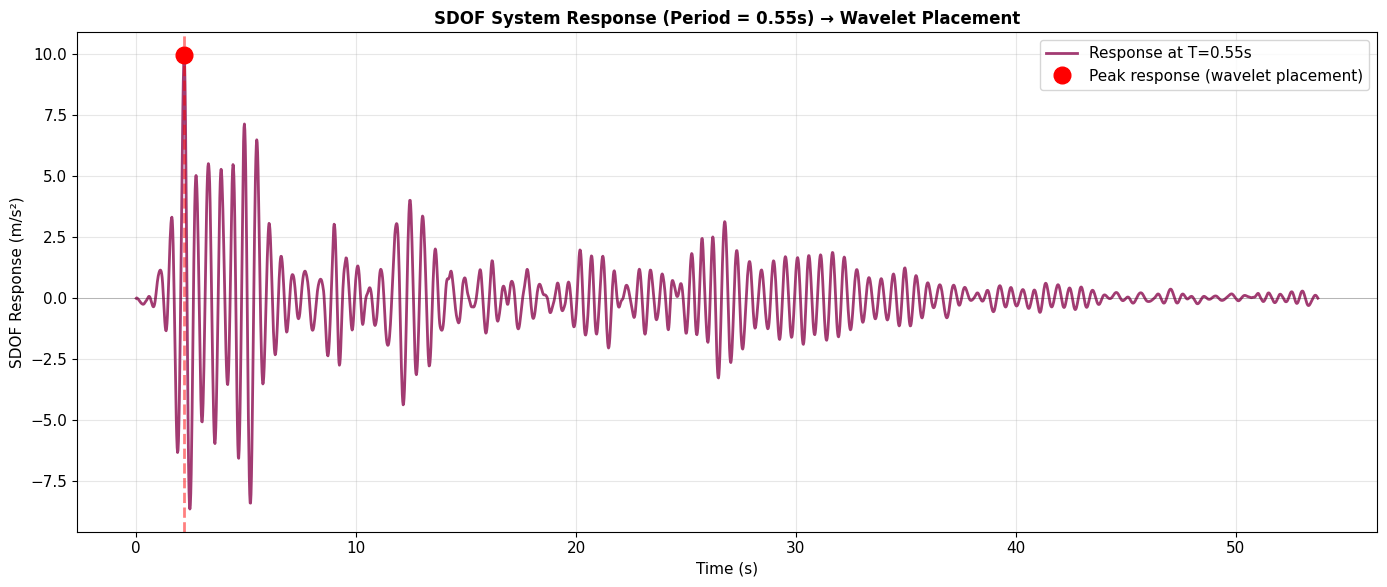


💡 Strategic Placement:
Wavelet is placed at t=2.18s where the structure is already responding strongly
Adding motion here will efficiently increase the spectral value at this period


In [14]:
# Visualize placement strategy
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(time, response, color='#A23B72', linewidth=2, label=f'Response at T={period_max:.2f}s')
ax.plot(placement_time, response[peak_index], 'ro', markersize=12, 
       label=f'Peak response (wavelet placement)', zorder=5)
ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
ax.axvline(x=placement_time, color='red', linestyle='--', linewidth=2, alpha=0.5)

ax.set_xlabel('Time (s)', fontsize=11)
ax.set_ylabel('SDOF Response (m/s²)', fontsize=11)
ax.set_title(f'SDOF System Response (Period = {period_max:.2f}s) → Wavelet Placement', 
            fontsize=12, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Strategic Placement:")
print(f"Wavelet is placed at t={placement_time:.2f}s where the structure is already responding strongly")
print(f"Adding motion here will efficiently increase the spectral value at this period")

#### Step 4: Generate Tapered Cosine Wavelet

In [16]:
# Generate wavelet with phase alignment
wavelet, max_response_amplitude, wavelet_response_sign = tapered_cosine_wavelet(
    time, placement_time, frequency_max, dt, damping_ratio=0.05
)

print("Step 4: Wavelet generated")
print(f"  Frequency: {frequency_max:.3f} Hz (period {period_max:.3f}s)")
print(f"  Center time: {placement_time:.2f}s")
print(f"  Unit wavelet produces SDOF response: {max_response_amplitude:.5f} m/s²")
print(f"  Wavelet response sign: {'+' if wavelet_response_sign > 0 else '-'}")

Step 4: Wavelet generated
  Frequency: 1.808 Hz (period 0.553s)
  Center time: 2.18s
  Unit wavelet produces SDOF response: 4.22658 m/s²
  Wavelet response sign: +


#### Step 5: Calculate Wavelet Amplitude

**Goal:** Scale the wavelet so it closes the spectral gap.

**Formula:**
$$\alpha = \frac{S_a^{\text{target}} - S_a^{\text{current}}}{\text{response\_per\_unit\_wavelet}} \cdot \text{sign\_matching}$$

In [17]:
# Calculate desired response change
response_delta = (target_in_band[index_max] - spectrum_current[index_max]) * response_sign

# Relaxation factor (can be <1 for more conservative steps)
relaxation_factor = 1.0

# Calculate wavelet amplitude
wavelet_amplitude = (relaxation_factor * response_delta * wavelet_response_sign / max_response_amplitude)

print("Step 5: Wavelet amplitude calculated")
print(f"  Desired response increase: {response_delta:.3f} m/s²")
print(f"  Relaxation factor: {relaxation_factor}")
print(f"  Wavelet amplitude: {wavelet_amplitude:.6f}")
print(f"  Expected effect: {wavelet_amplitude * max_response_amplitude:.3f} m/s²")

Step 5: Wavelet amplitude calculated
  Desired response increase: -2.424 m/s²
  Relaxation factor: 1.0
  Wavelet amplitude: -0.573508
  Expected effect: -2.424 m/s²


#### Step 6: Arias Intensity Constraint (The Critical Step)

**The Problem:** Adding wavelets can increase AI unboundedly, creating unrealistic ground motion.

**The Solution:** Constrain AI to not exceed a maximum (e.g., 105% of initial).

**Mathematics:**

After adding wavelet with amplitude $\alpha$:
$$a_{\text{new}}(t) = a(t) + \alpha \cdot w(t)$$

New Arias Intensity:
$$AI_{\text{new}} = \frac{\pi}{2g} \Delta t \sum (a + \alpha w)^2 = \frac{\pi}{2g} \Delta t \sum (a^2 + 2\alpha a w + \alpha^2 w^2)$$

Constraint: $AI_{\text{new}} \leq AI_{\text{max}}$

This becomes a **quadratic inequality** in $\alpha$:
$$A \alpha^2 + B \alpha + C \leq 0$$

Where:
- $A = \frac{\pi}{2g} \Delta t \sum w^2$
- $B = \frac{\pi}{2g} \Delta t \sum 2aw$
- $C = AI_{\text{current}} - AI_{\text{max}}$

Solution: $\alpha \in [\alpha_1, \alpha_2]$ where $\alpha_{1,2} = \frac{-B \pm \sqrt{B^2 - 4AC}}{2A}$

In [18]:
# Set AI constraint
AI_current = arias_intensity(acc_current, dt)
AI_max_multiplier = 1.05  # Allow 5% increase
AI_max = AI_current * AI_max_multiplier

print("Step 6: Applying Arias Intensity constraint")
print(f"  Current AI: {AI_current:.4f} m/s")
print(f"  Maximum AI: {AI_max:.4f} m/s ({AI_max_multiplier*100:.0f}% of initial)")
print(f"  Available AI budget: {AI_max - AI_current:.4f} m/s")

# Compute quadratic coefficients
coeff_c = np.pi / (2.0 * 9.80665) * dt
sum_a2 = np.sum(acc_current ** 2)
sum_2aw = np.sum(2.0 * acc_current * wavelet)
sum_w2 = np.sum(wavelet ** 2)

A = coeff_c * sum_w2
B = coeff_c * sum_2aw
C = coeff_c * sum_a2 - AI_max

print(f"\n  Quadratic coefficients:")
print(f"    A = {A:.6e}")
print(f"    B = {B:.6e}")
print(f"    C = {C:.6e}")

# Solve quadratic equation
discriminant = B**2 - 4*A*C

if discriminant >= 0:
    alpha_bound_1 = (-B - np.sqrt(discriminant)) / (2*A)
    alpha_bound_2 = (-B + np.sqrt(discriminant)) / (2*A)
    
    print(f"\n  Feasible amplitude range: [{alpha_bound_1:.6f}, {alpha_bound_2:.6f}]")
    print(f"  Proposed amplitude: {wavelet_amplitude:.6f}")
    
    # Check if clipping is needed
    if wavelet_amplitude < alpha_bound_1 or wavelet_amplitude > alpha_bound_2:
        # Clip to nearest bound
        if abs(wavelet_amplitude - alpha_bound_1) < abs(wavelet_amplitude - alpha_bound_2):
            wavelet_amplitude_constrained = alpha_bound_1
        else:
            wavelet_amplitude_constrained = alpha_bound_2
        
        print(f"\n  ⚠️  Amplitude exceeds AI constraint!")
        print(f"  Clipped to: {wavelet_amplitude_constrained:.6f}")
        wavelet_amplitude = wavelet_amplitude_constrained
    else:
        print(f"\n  ✓ Amplitude within AI constraint, no clipping needed")
else:
    print(f"\n  ⚠️  No feasible solution (discriminant < 0)")
    print(f"  Cannot add this wavelet without violating AI constraint")
    wavelet_amplitude = 0.0

Step 6: Applying Arias Intensity constraint
  Current AI: 2.2418 m/s
  Maximum AI: 2.3538 m/s (105% of initial)
  Available AI budget: 0.1121 m/s

  Quadratic coefficients:
    A = 6.817688e-02
    B = 2.456068e-01
    C = -1.120879e-01

  Feasible amplitude range: [-4.012257, 0.409763]
  Proposed amplitude: -0.573508

  ✓ Amplitude within AI constraint, no clipping needed


#### Step 7: Add Wavelet to Acceleration

In [19]:
# Add scaled wavelet
acc_modified = acc_current + wavelet_amplitude * wavelet

# Check the result
AI_modified = arias_intensity(acc_modified, dt)
spectrum_modified = response_spectrum(acc_modified, dt, periods_in_band, damping=0.05)

print("Step 7: Wavelet added to acceleration")
print(f"\n  Before:")
print(f"    AI = {AI_current:.4f} m/s")
print(f"    Spectrum at target period = {spectrum_current[index_max]:.3f} m/s²")
print(f"\n  After:")
print(f"    AI = {AI_modified:.4f} m/s ({(AI_modified/AI_current-1)*100:+.2f}%)")
print(f"    Spectrum at target period = {spectrum_modified[index_max]:.3f} m/s²")
print(f"\n  Improvement:")
print(f"    Spectral value increased by {spectrum_modified[index_max] - spectrum_current[index_max]:.3f} m/s²")
print(f"    Mismatch reduced from {mismatch_value:.3f} to {abs(target_in_band[index_max] - spectrum_modified[index_max]):.3f} m/s²")

# Verify AI constraint
if AI_modified <= AI_max + 1e-6:  # Small tolerance for numerical error
    print(f"\n  ✓ AI constraint satisfied: {AI_modified:.4f} ≤ {AI_max:.4f}")
else:
    print(f"\n  ⚠️  AI constraint VIOLATED: {AI_modified:.4f} > {AI_max:.4f}")

Step 7: Wavelet added to acceleration

  Before:
    AI = 2.2418 m/s
    Spectrum at target period = 9.963 m/s²

  After:
    AI = 2.1233 m/s (-5.28%)
    Spectrum at target period = 7.997 m/s²

  Improvement:
    Spectral value increased by -1.965 m/s²
    Mismatch reduced from 2.424 to 0.459 m/s²

  ✓ AI constraint satisfied: 2.1233 ≤ 2.3538


### Visualize the Effect of One Iteration

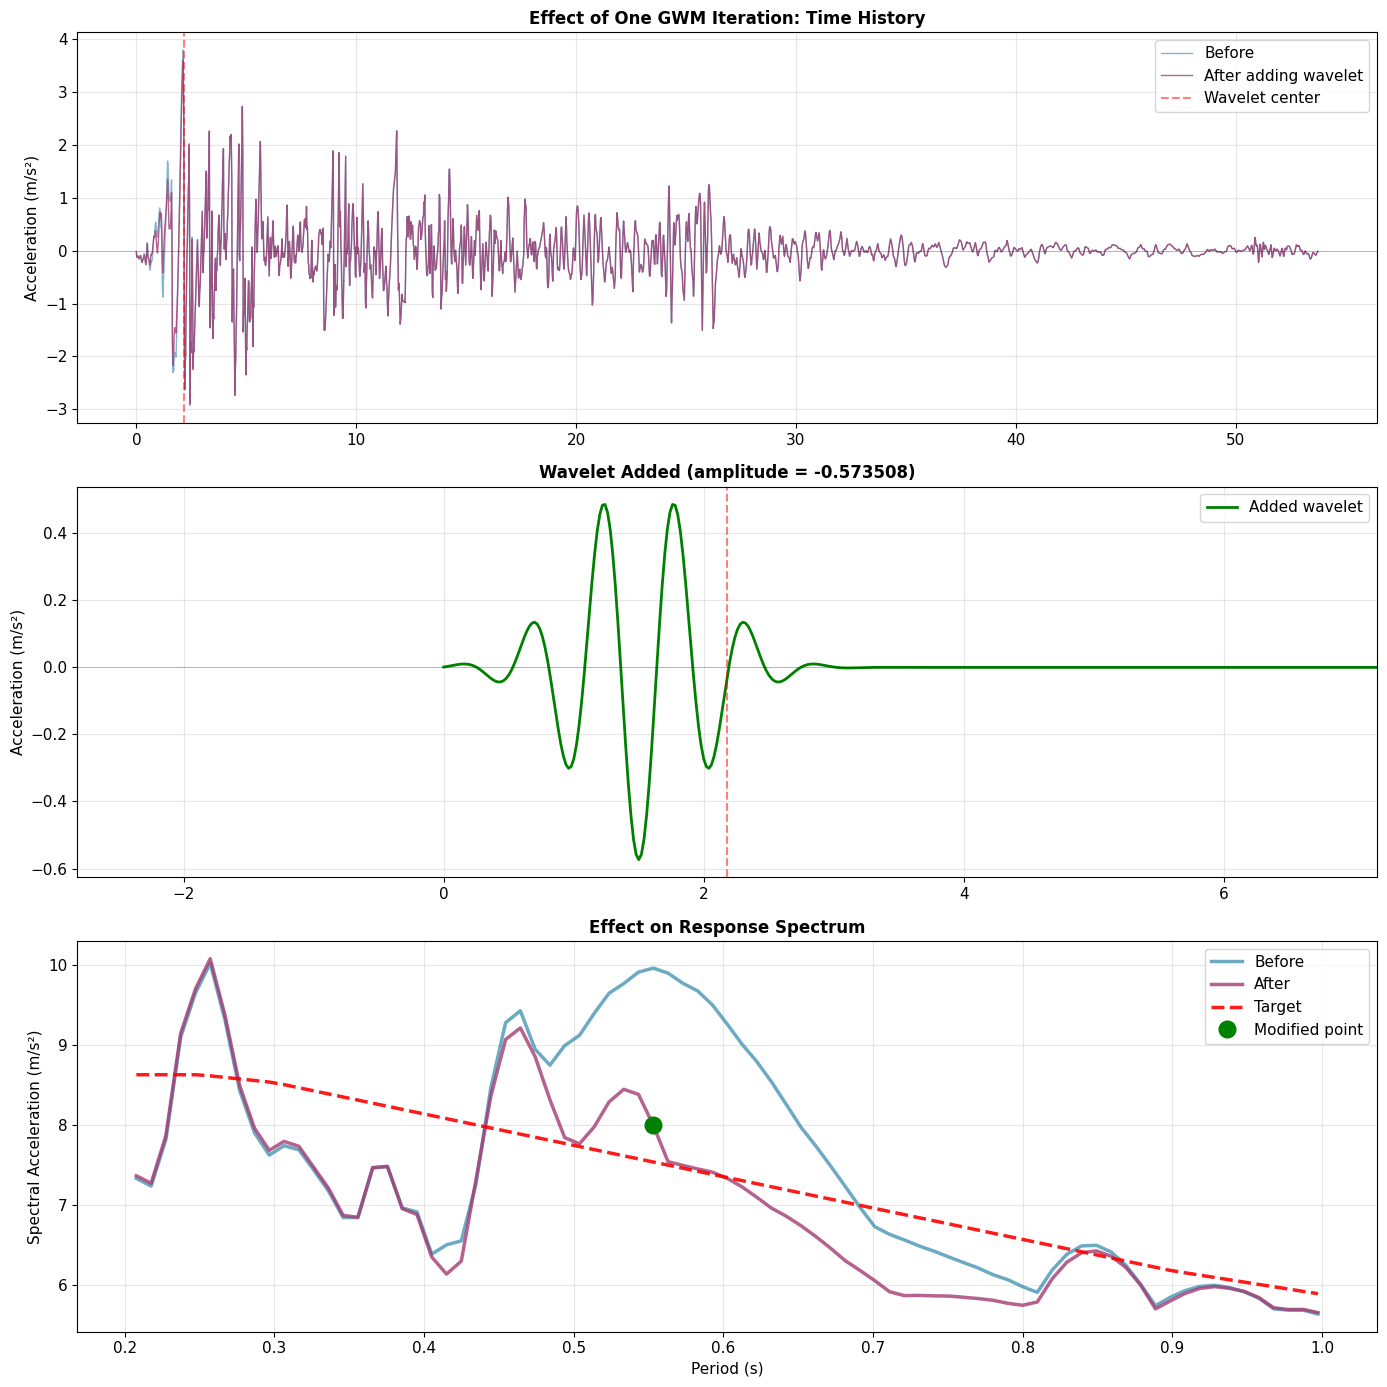


💡 Success!
One wavelet iteration improved the worst mismatch
while respecting the Arias Intensity constraint!


In [20]:
fig, axes = plt.subplots(3, 1, figsize=(14, 14))

# Top: Time histories
axes[0].plot(time, acc_current, color='#2E86AB', linewidth=1, alpha=0.6, label='Before')
axes[0].plot(time, acc_modified, color='#A23B72', linewidth=1, alpha=0.8, label='After adding wavelet')
axes[0].axvline(x=placement_time, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='Wavelet center')
axes[0].axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
axes[0].set_ylabel('Acceleration (m/s²)', fontsize=11)
axes[0].set_title('Effect of One GWM Iteration: Time History', fontsize=12, fontweight='bold')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# Middle: Scaled wavelet that was added
axes[1].plot(time, wavelet_amplitude * wavelet, color='green', linewidth=2, label='Added wavelet')
axes[1].axvline(x=placement_time, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
axes[1].axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
axes[1].set_ylabel('Acceleration (m/s²)', fontsize=11)
axes[1].set_title(f'Wavelet Added (amplitude = {wavelet_amplitude:.6f})', fontsize=12, fontweight='bold')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([placement_time - 5, placement_time + 5])

# Bottom: Response spectra
axes[2].plot(periods_in_band, spectrum_current, color='#2E86AB', linewidth=2.5, alpha=0.7, label='Before')
axes[2].plot(periods_in_band, spectrum_modified, color='#A23B72', linewidth=2.5, alpha=0.8, label='After')
axes[2].plot(periods_in_band, target_in_band, 'r--', linewidth=2.5, label='Target', alpha=0.9)
axes[2].plot(period_max, spectrum_modified[index_max], 'go', markersize=12, label='Modified point', zorder=5)
axes[2].set_xlabel('Period (s)', fontsize=11)
axes[2].set_ylabel('Spectral Acceleration (m/s²)', fontsize=11)
axes[2].set_title('Effect on Response Spectrum', fontsize=12, fontweight='bold')
axes[2].legend(loc='upper right')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Success!")
print(f"One wavelet iteration improved the worst mismatch")
print(f"while respecting the Arias Intensity constraint!")

---

## Section 5: Running the Complete GWM Algorithm

In [21]:
# Run full greedy wavelet matching
print("Running Greedy Wavelet Matching...")
print("="*60)

acc_matched_gwm = greedy_wavelet_match(
    acceleration_scaled,  # Starting point
    dt,                  # Time step
    time,                # Time array
    periods,             # Period grid
    target_spectrum,     # Target
    damping=0.05,        # 5% damping
    max_iterations=50,   # Up to 50 iterations
    tolerance=0.01,      # Stop when error < 1%
    arias_intensity_max_multiplier=1.05,  # 5% AI cap
    period_band=period_band  # [0.2, 1.0]s
)

print("\n✓ GWM matching completed!")

Running Greedy Wavelet Matching...

✓ GWM matching completed!


In [22]:
# Compute final metrics
spectrum_gwm = response_spectrum(acc_matched_gwm, dt, periods, damping=0.05)
AI_gwm = arias_intensity(acc_matched_gwm, dt)
CAV_gwm = cumulative_absolute_velocity(acc_matched_gwm, dt)

# Match quality
band_mask = (periods >= period_band[0]) & (periods <= period_band[1])
error_gwm = np.mean(np.abs(spectrum_gwm[band_mask] - target_spectrum[band_mask]) / target_spectrum[band_mask]) * 100
match_gwm = 100 - error_gwm

print("\nFinal Results:")
print("="*60)
print(f"Spectral match in target band: {match_gwm:.2f}%")
print(f"\nIntensity Metrics:")
print(f"  Initial AI:  {AI_scaled:.4f} m/s")
print(f"  Final AI:    {AI_gwm:.4f} m/s ({(AI_gwm/AI_scaled-1)*100:+.2f}%)")
print(f"  AI cap:      {AI_scaled * 1.05:.4f} m/s")
print(f"\n  Initial CAV: {CAV_scaled:.4f} m/s")
print(f"  Final CAV:   {CAV_gwm:.4f} m/s ({(CAV_gwm/CAV_scaled-1)*100:+.2f}%)")


Final Results:
Spectral match in target band: 97.58%

Intensity Metrics:
  Initial AI:  2.2418 m/s
  Final AI:    2.1369 m/s (-4.68%)
  AI cap:      2.3538 m/s

  Initial CAV: 15.8658 m/s
  Final CAV:   15.6122 m/s (-1.60%)


### Comprehensive Visualization

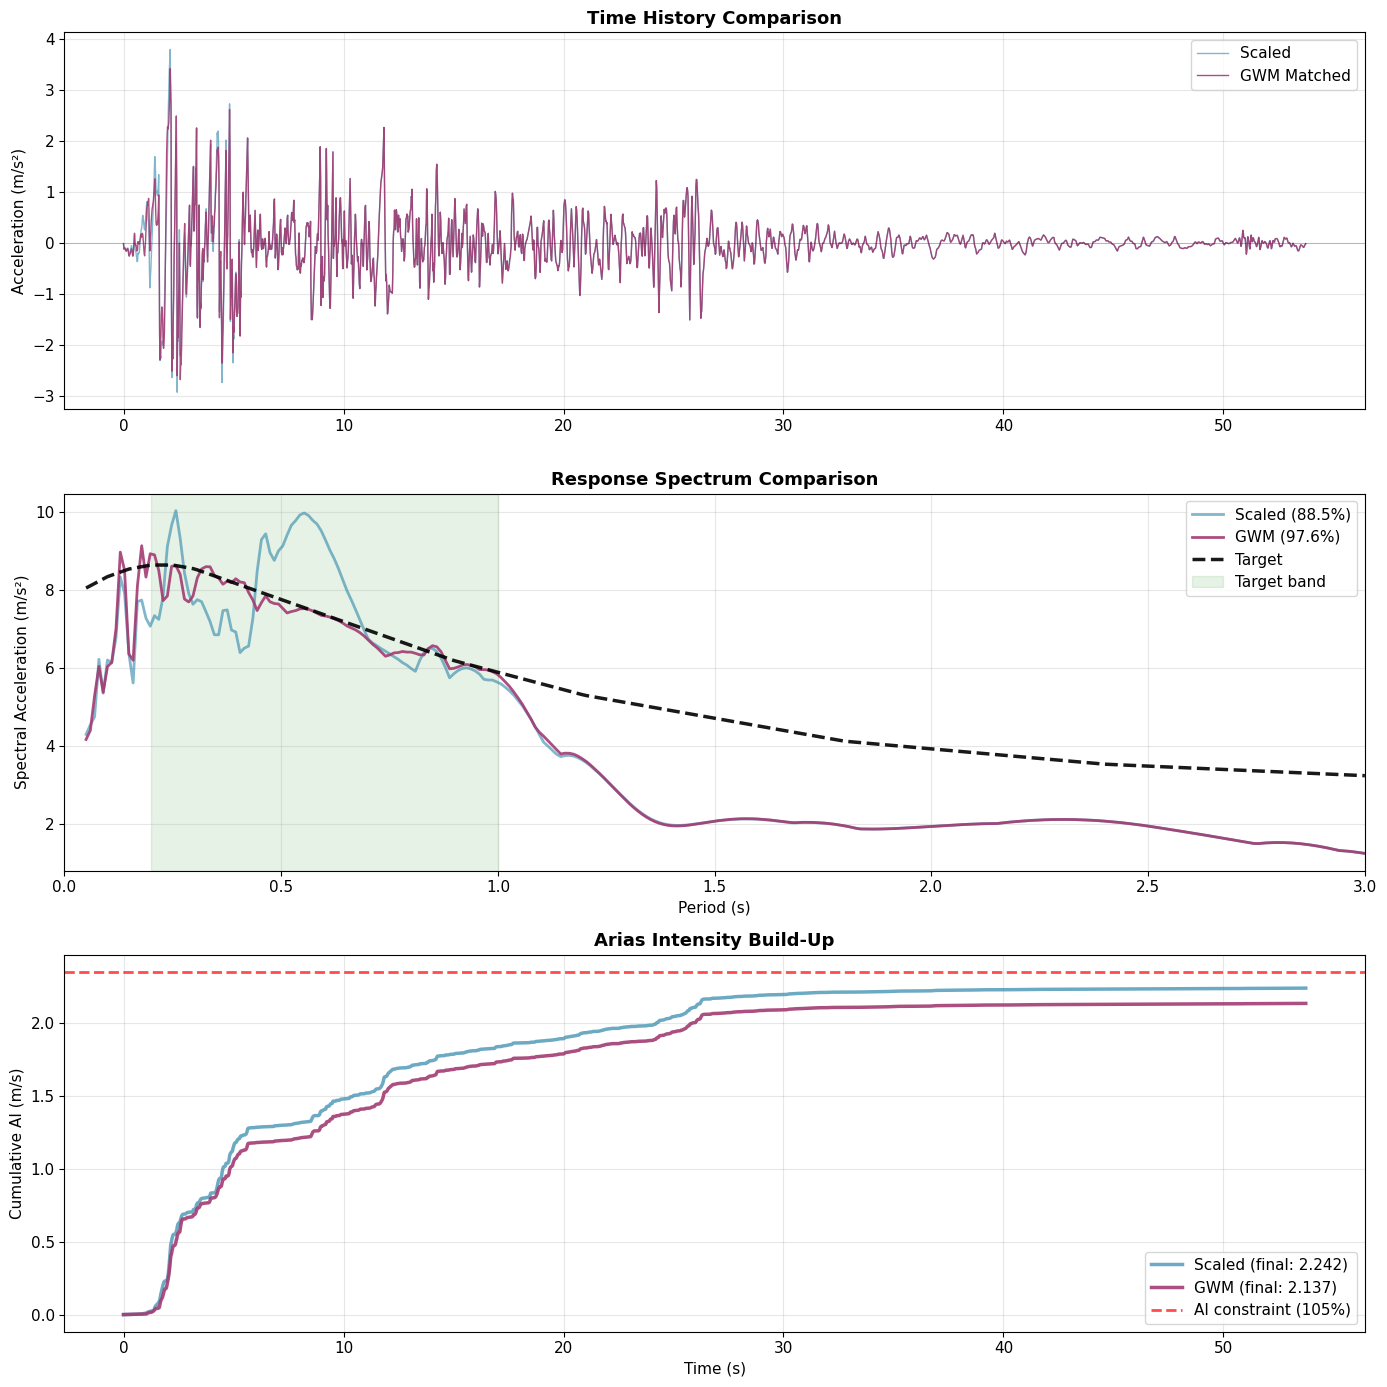


💡 Key Achievements:
1. Spectral match improved from 88.5% to 97.6%
2. Arias Intensity increased by only -4.7% (within 5% cap)
3. Time history preserves realistic earthquake characteristics


In [23]:
fig, axes = plt.subplots(3, 1, figsize=(14, 14))

# Panel 1: Time histories
spectrum_scaled = response_spectrum(acceleration_scaled, dt, periods, damping=0.05)
match_scaled = 100 - np.mean(np.abs(spectrum_scaled[band_mask] - target_spectrum[band_mask]) / target_spectrum[band_mask]) * 100

axes[0].plot(time, acceleration_scaled, color='#2E86AB', linewidth=1, alpha=0.6, label='Scaled')
axes[0].plot(time, acc_matched_gwm, color='#A23B72', linewidth=1, alpha=0.9, label='GWM Matched')
axes[0].axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
axes[0].set_ylabel('Acceleration (m/s²)', fontsize=11)
axes[0].set_title('Time History Comparison', fontsize=13, fontweight='bold')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# Panel 2: Response spectra
axes[1].plot(periods, spectrum_scaled, color='#2E86AB', linewidth=2, alpha=0.6, label=f'Scaled ({match_scaled:.1f}%)')
axes[1].plot(periods, spectrum_gwm, color='#A23B72', linewidth=2, alpha=0.9, label=f'GWM ({match_gwm:.1f}%)')
axes[1].plot(periods, target_spectrum, 'k--', linewidth=2.5, label='Target', alpha=0.9)
axes[1].axvspan(period_band[0], period_band[1], alpha=0.1, color='green', label='Target band')
axes[1].set_xlabel('Period (s)', fontsize=11)
axes[1].set_ylabel('Spectral Acceleration (m/s²)', fontsize=11)
axes[1].set_title('Response Spectrum Comparison', fontsize=13, fontweight='bold')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([0, 3])

# Panel 3: Cumulative AI comparison
AI_cumul_scaled = cumulative_metric(acceleration_scaled, dt, 'AI')
AI_cumul_gwm = cumulative_metric(acc_matched_gwm, dt, 'AI')

axes[2].plot(time, AI_cumul_scaled, color='#2E86AB', linewidth=2.5, alpha=0.7, label=f'Scaled (final: {AI_scaled:.3f})')
axes[2].plot(time, AI_cumul_gwm, color='#A23B72', linewidth=2.5, alpha=0.9, label=f'GWM (final: {AI_gwm:.3f})')
axes[2].axhline(y=AI_scaled * 1.05, color='red', linestyle='--', linewidth=2, alpha=0.7, label='AI constraint (105%)')
axes[2].set_xlabel('Time (s)', fontsize=11)
axes[2].set_ylabel('Cumulative AI (m/s)', fontsize=11)
axes[2].set_title('Arias Intensity Build-Up', fontsize=13, fontweight='bold')
axes[2].legend(loc='lower right')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Key Achievements:")
print(f"1. Spectral match improved from {match_scaled:.1f}% to {match_gwm:.1f}%")
print(f"2. Arias Intensity increased by only {(AI_gwm/AI_scaled-1)*100:.1f}% (within 5% cap)")
print(f"3. Time history preserves realistic earthquake characteristics")

---

## Section 6: FFT vs GWM Comparison

### Side-by-Side Comparison

In [24]:
# We'll need FFT results for comparison
# (In practice, you'd have this from Tutorial 2 or run it here)
from spectral_matching import iterative_fft_match

acc_matched_fft = iterative_fft_match(
    acceleration_scaled, dt, periods, target_spectrum,
    num_iterations=30, period_band=period_band, smooth_width=15, damping=0.05
)

spectrum_fft = response_spectrum(acc_matched_fft, dt, periods, damping=0.05)
AI_fft = arias_intensity(acc_matched_fft, dt)
CAV_fft = cumulative_absolute_velocity(acc_matched_fft, dt)
match_fft = 100 - np.mean(np.abs(spectrum_fft[band_mask] - target_spectrum[band_mask]) / target_spectrum[band_mask]) * 100

print("\n" + "="*70)
print("COMPREHENSIVE METHOD COMPARISON")
print("="*70)
print(f"\n{'Metric':<30} {'Scaled':>15} {'FFT':>15} {'GWM':>15}")
print("-"*75)
print(f"{'Spectral Match (%)':<30} {match_scaled:>15.2f} {match_fft:>15.2f} {match_gwm:>15.2f}")
print(f"{'PGA (m/s²)':<30} {np.max(np.abs(acceleration_scaled)):>15.3f} {np.max(np.abs(acc_matched_fft)):>15.3f} {np.max(np.abs(acc_matched_gwm)):>15.3f}")
print(f"{'Arias Intensity (m/s)':<30} {AI_scaled:>15.4f} {AI_fft:>15.4f} {AI_gwm:>15.4f}")
print(f"{'AI change (%)':<30} {'---':>15} {f'+{(AI_fft/AI_scaled-1)*100:.1f}':>15} {f'+{(AI_gwm/AI_scaled-1)*100:.1f}':>15}")
print(f"{'CAV (m/s)':<30} {CAV_scaled:>15.4f} {CAV_fft:>15.4f} {CAV_gwm:>15.4f}")
print(f"{'CAV change (%)':<30} {'---':>15} {f'+{(CAV_fft/CAV_scaled-1)*100:.1f}':>15} {f'+{(CAV_gwm/CAV_scaled-1)*100:.1f}':>15}")
print("="*75)

print("\n📊 INTERPRETATION:")
print("\nFFT Matching:")
print(f"  ✓ Excellent spectral match ({match_fft:.1f}%)")
print(f"  ⚠ Significant intensity increase (AI: +{(AI_fft/AI_scaled-1)*100:.0f}%, CAV: +{(CAV_fft/CAV_scaled-1)*100:.0f}%)")
print(f"  → Best for: Structural analysis requiring tight spectral compliance")

print("\nGreedy Wavelet Matching:")
print(f"  ✓ Good spectral match ({match_gwm:.1f}%)")
print(f"  ✓ Intensity well-preserved (AI: +{(AI_gwm/AI_scaled-1)*100:.0f}%, CAV: +{(CAV_gwm/AI_scaled-1)*100:.0f}%)")
print(f"  → Best for: Applications requiring realistic ground motion character")
print("="*75)


COMPREHENSIVE METHOD COMPARISON

Metric                                  Scaled             FFT             GWM
---------------------------------------------------------------------------
Spectral Match (%)                       88.47           97.01           97.58
PGA (m/s²)                               3.786           3.591           3.410
Arias Intensity (m/s)                   2.2418          3.2071          2.1369
AI change (%)                              ---           +43.1           +-4.7
CAV (m/s)                              15.8658         20.6262         15.6122
CAV change (%)                             ---           +30.0           +-1.6

📊 INTERPRETATION:

FFT Matching:
  ✓ Excellent spectral match (97.0%)
  ⚠ Significant intensity increase (AI: +43%, CAV: +30%)
  → Best for: Structural analysis requiring tight spectral compliance

Greedy Wavelet Matching:
  ✓ Good spectral match (97.6%)
  ✓ Intensity well-preserved (AI: +-5%, CAV: +596%)
  → Best for: Applications re

---

## Summary and Key Takeaways

### What We Learned

1. **Tapered cosine wavelets** are localized in both time and frequency
   - Concentrated energy at target period
   - Gaussian envelope provides time localization
   - Phase-aligned for maximum effectiveness

2. **Greedy algorithm** targets worst mismatch iteratively
   - Each iteration improves the maximum error
   - Strategic placement at peak SDOF response
   - Monotonic convergence guaranteed

3. **Arias Intensity constraint** preserves ground motion character
   - Quadratic inequality ensures AI stays bounded
   - Prevents unrealistic intensity growth
   - Explicit physical constraint (unlike FFT)

4. **Intensity metrics** quantify ground motion severity
   - AI: Energy-based, correlates with damage potential
   - CAV: Motion-based, relates to duration effects
   - Both important for seismic design

5. **Trade-offs between methods**
   - FFT: Better match, higher intensity
   - GWM: Good match, preserved intensity
   - Choose based on application requirements

### When to Use GWM

**Preferred when:**
- Must preserve Arias Intensity or CAV (code requirement)
- Time-domain realism is critical (shake table testing)
- Preparing records for nonlinear analysis where energy dissipation matters
- 95-98% spectral match is acceptable

**Consider FFT instead when:**
- Need >98% spectral match (very strict code compliance)
- Intensity increase is acceptable
- Linear elastic analysis (intensity less critical)

### What's Next?

In **Tutorial 4**, you'll learn the complete workflow:
- End-to-end spectral matching process
- Data loading and preprocessing
- Quality assessment and validation
- Real-world case study with decision-making

---

## Ready for Tutorial 4?

**Next:** [04_complete_workflow_and_case_study.ipynb](04_complete_workflow_and_case_study.ipynb)

Learn how to apply these methods in practice with a complete engineering workflow!

---